In [1]:
import os.path
import matplotlib.pyplot as plt

import ramanchada2 as rc2
import ramanchada2.misc.constants as rc2const
from ramanchada2.protocols.calibration.calibration_model import CalibrationModel
import traceback
import warnings 
warnings.filterwarnings("ignore")


In [2]:
#
def find_peaks(spe_test,profile="Gaussian",vary_baseline=False):
    find_kw={"wlen": 200, "width": 1, "sharpening" : None}
    find_kw["prominence"] = spe_test.y_noise_MAD() * 3
    cand = spe_test.find_peak_multipeak(**find_kw)
    fit_kw = {}
    return spe_test.fit_peak_multimodel(profile=profile,candidates=cand, **fit_kw ,no_fit=False,vary_baseline=vary_baseline) , cand

# 1. Load Ne and Si spectra
and do basic preprocessing and plotting

In [3]:

# 
laser_wl = 785

In [4]:
# We use test spectra for this demo.  You can load the spectra from local files instead.
provider = "ICV"
optical_path = "100"
device = "BWtek"


print(f"We will load test spectra by {provider} {device} laser wavelength {laser_wl} optical path {optical_path}.")

We will load test spectra by ICV BWtek laser wavelength 785 optical path 100.


Text(0.5, 0, 'Raman shift [cm$^{-1}$]')

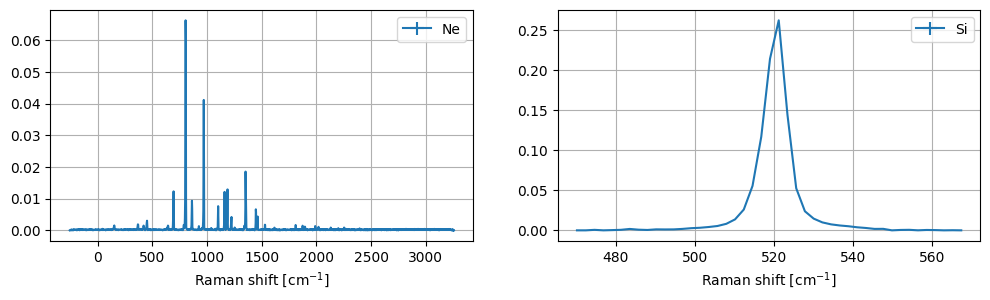

In [5]:
spe_neon = rc2.spectrum.from_test_spe(
            sample=["Neon"], provider=[provider], device=[device], OP=[optical_path], laser_wl=[str(laser_wl)]
        )
spe_neon = spe_neon.subtract_baseline_rc1_snip(niter= 40)

spe_sil = rc2.spectrum.from_test_spe(
            sample=["S0B"], provider=[provider], device=[device], OP=[optical_path], laser_wl=[str(laser_wl)]
        )

_crop = 50  # this may affect Pearson4 fitting quality
spe_sil = spe_sil.trim_axes(
            method="x-axis", boundaries=(max(100, 520.45 - _crop), 520.45 + _crop)
        ).subtract_baseline_rc1_snip(niter= 40)

normalize_strategy = "unity" # None
if normalize_strategy is not None:
    spe_neon = spe_neon.normalize(strategy=normalize_strategy)
    spe_sil = spe_sil.normalize(strategy=normalize_strategy)

# Plot spectra
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))
spe_neon.plot(label='Ne',ax=ax1)
spe_sil.plot(label="Si",ax=ax2)
ax2.grid()
ax1.grid()
ax1.set_xlabel('Raman shift [cm$^{-1}$]')
ax2.set_xlabel('Raman shift [cm$^{-1}$]')

# 2. Create calibration model (both Si and Ne)


In [6]:
try:
    fit_neon_peaks = True
    # False should be used for testing only . Fitting may take a while .
    neon_wl = rc2const.NEON_WL[laser_wl]
    calmodel = CalibrationModel.calibration_model_factory(
        laser_wl,
        spe_neon,
        spe_sil,
        neon_wl=neon_wl,
        find_kw={"wlen": 200, "width": 1},
        fit_peaks_kw={},
        should_fit=fit_neon_peaks,
        match_method="cluster",
        interpolator_method="pchip"
    )
    assert len(calmodel.components) == 2
    print(type(calmodel.components[0]),calmodel.components[0])
    print(type(calmodel.components[1]),calmodel.components[1])
    #print(calmodel.components[1].profile, calmodel.components[1].peaks)
except Exception as _err:
    calmodel = None
    traceback.print_exc()

<class 'ramanchada2.protocols.calibration.xcalibration.XCalibrationComponent'> Neon calibration spe (cm-1) reference (nm) model (nm) Calibration curve 22 points) (PchipInterpolator)
<class 'ramanchada2.protocols.calibration.xcalibration.LazerZeroingComponent'> Laser zeroing using 818.3581697620177 nm 520.45 cm-1 (Pearson4)  spe (nm) reference (cm-1) model (nm) 818.3581697620177


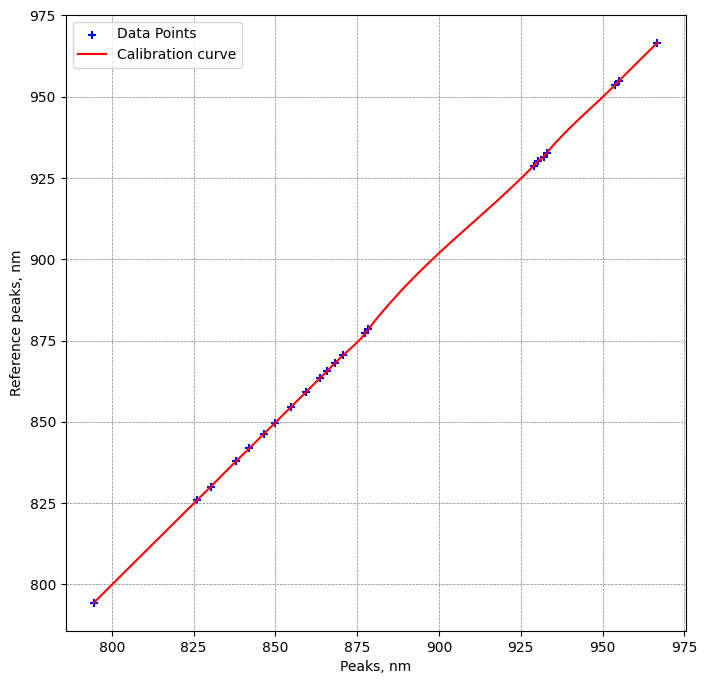

In [7]:
# plot calibration curve

model_neon = calmodel.components[0]
fig,ax=plt.subplots(1,1,figsize=(8,8))

model_neon.model.plot(ax=ax )

# one can apply the calibration curve to arbitrary vector
# x_range = np.linspace(700,1000, 100)  
# predicted_x =  model_neon.model(x_range.reshape(-1, 1)) 
# ax.plot(x_range,predicted_x,marker='.')


In [8]:
model_neon.matched_peaks

,spe,reference,distances
0,794.473449,794.345733,0.017956
1,826.142860,825.986843,0.024713
2,830.241714,830.056893,0.036280
3,837.883877,837.803063,0.029126
4,842.043299,841.866454,0.039936
5,846.552017,846.380744,0.029758
6,849.770874,849.575492,0.042221
7,854.697619,854.520788,0.031271
8,859.348375,859.159737,0.150578
9,863.692279,863.492341,0.071053


In [9]:
# calmodel.components[0].matched_peaks

# 3. Apply calibration

In [10]:
# This is the only row we need for calibrating a new spectrum
spe_sil_calibrated = calmodel.apply_calibration_x(spe_sil)


In [11]:
# Let's verfy the peak in the calibrated Si is at the right position 
       

fitres, cand = find_peaks(spe_sil_calibrated,profile="Pearson4")
df = fitres.to_dataframe_peaks().sort_values(by="height",ascending=False)
df

,amplitude,amplitude_stderr,center,center_stderr,sigma,sigma_stderr,expon,expon_stderr,skew,skew_stderr,fwhm,fwhm_stderr,height,height_stderr,position,position_stderr
g00_p0,2.174306,0.022803,520.45408,0.095656,4.060509,0.1413,1.526296,0.065744,0.385968,0.057006,6.543488,0.092647,0.269447,0.001997,519.940672,0.030362


In [12]:
si_peak_found = df.iloc[0]["center"]

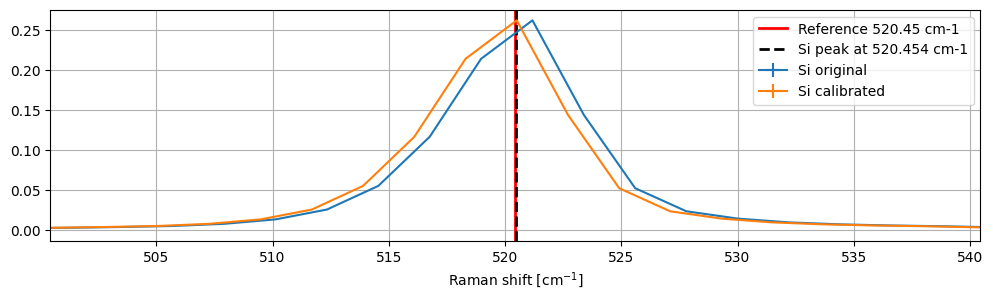

In [13]:
# plots
fig, ax = plt.subplots(1,1,figsize=(12,3))
spe_sil.plot(ax=ax,label="Si original")
spe_sil_calibrated.plot(ax=ax,label="Si calibrated")
ax.set_xlabel('Raman shift [cm$^{-1}$]')
ax.axvline(x=520.45, color='red', linestyle='-', linewidth=2, label="Reference 520.45 cm-1")
ax.set_xlim(520.45-20,520.45+20)
ax.axvline(x=si_peak_found, color='black', linestyle='--', linewidth=2, label="Si peak at {:.3f} cm-1".format(si_peak_found))
ax.legend()
plt.grid()
plt.show()

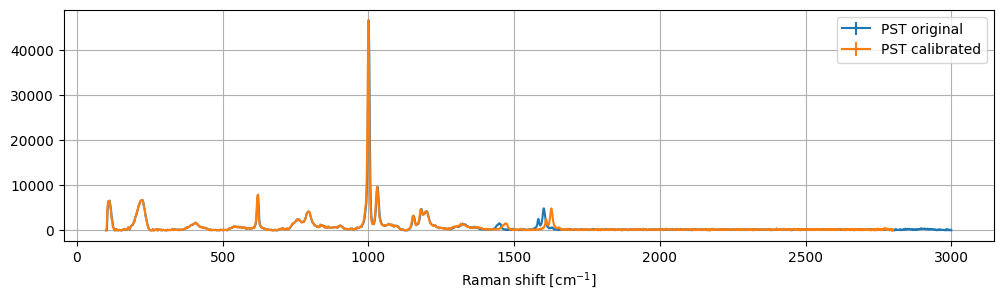

In [14]:
# apply calibration to another spectrum (e.g. PST)
spe_pst = rc2.spectrum.from_test_spe(
            sample=["PST"], provider=[provider], device=[device], OP=[optical_path], laser_wl=[str(laser_wl)]
        )
spe_pst = spe_pst.trim_axes(method="x-axis", boundaries=(100, max(spe_pst.x))).subtract_baseline_rc1_snip(niter= 40)
spe_pst_calibrated = calmodel.apply_calibration_x(spe_pst)

# plots
fig, ax = plt.subplots(1,1,figsize=(12,3))
spe_pst.plot(ax=ax,label="PST original")
spe_pst_calibrated.plot(ax=ax,label="PST calibrated")
ax.set_xlabel('Raman shift [cm$^{-1}$]')
ax.legend()
plt.grid()
plt.show()


# ************ That's it ! ************

# 4. For advanced users 

One can create the components of the calibration model one by one to hae a full control of the options. 
However, the final result will be the same.  The recommended way is to use the calibration_model_factory as above.

## 4.1. Create calibration curve using Neon

In [15]:
# 4.1 Create calibration curve using Neon

fit_neon_peaks = True
# False should be used for testing only . Fitting may take a while .

neon_wl = rc2const.NEON_WL[laser_wl]
# these are reference Ne peaks

try:
    find_kw = {"wlen": 200, "width": 1}
    # options for finding peaks    
    fit_peaks_kw = {}
    # options for fitting peaks

    calmodel1 = CalibrationModel(laser_wl)
    # create CalibrationModel class. it does not derive a curve at this moment!
    calmodel1.prominence_coeff = 3
    find_kw["prominence"] = spe_neon.y_noise_MAD() * calmodel1.prominence_coeff

    model_neon1 = calmodel1.derive_model_curve(
        spe=spe_neon,
        ref=neon_wl,
        spe_units="cm-1",
        ref_units="nm",
        find_kw=find_kw,
        fit_peaks_kw=fit_peaks_kw,
        should_fit=fit_neon_peaks,
        name="Neon calibration",
        match_method="cluster",
        interpolator_method="cubic_spline",
        extrapolate=False
    )
    # now derive_model_curve finds peaks, fits peaks, matches peaks and derives the calibration curve
    # and model_neon.process() could be applied to Si or other spectra

except Exception as err:
    traceback.print_exc()


In [16]:
print(model_neon1)

Neon calibration spe (cm-1) reference (nm) model (nm) Calibration curve 22 points) (PchipInterpolator)


## 4.1.1 Explore the calibration curve (optional)

The Ne spectrum is converted to wavelength, nm , peaks are matched to the reference peaks and calibration curve is derived

,center,fwhm,height,amplitude
0,770.345475,0.079126,0.002118,3.680250e-05
1,1014.011126,0.483602,0.005679,1.379439e+13
2,775.910309,0.855382,0.000205,3.125786e-03
3,775.325930,0.497821,0.000028,5.773160e-13
4,780.913881,0.829264,0.000128,1.582666e-04
...,...,...,...,...
94,1035.760289,1.457904,0.000134,3.089470e-04
96,1042.301549,1.145680,0.000302,5.367588e-03
97,1046.575232,0.057941,0.000158,3.600909e-06
98,1049.850632,2.394785,0.000144,3.664941e-04


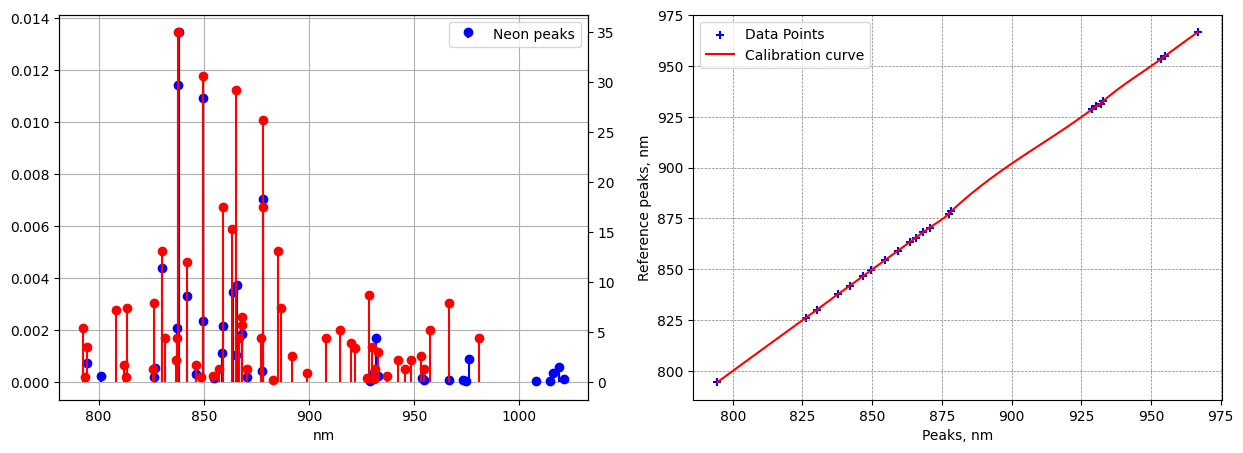

In [17]:
# Quick plot of Ne peaks (blue) and references (red)
fig, (ax , ax1) = plt.subplots(1,2,figsize=(15,5))
ax.grid()
ax1.grid()
calmodel1.plot(ax=ax)
model_neon.model.plot(ax=ax1)

model_neon1.peaks

Plot

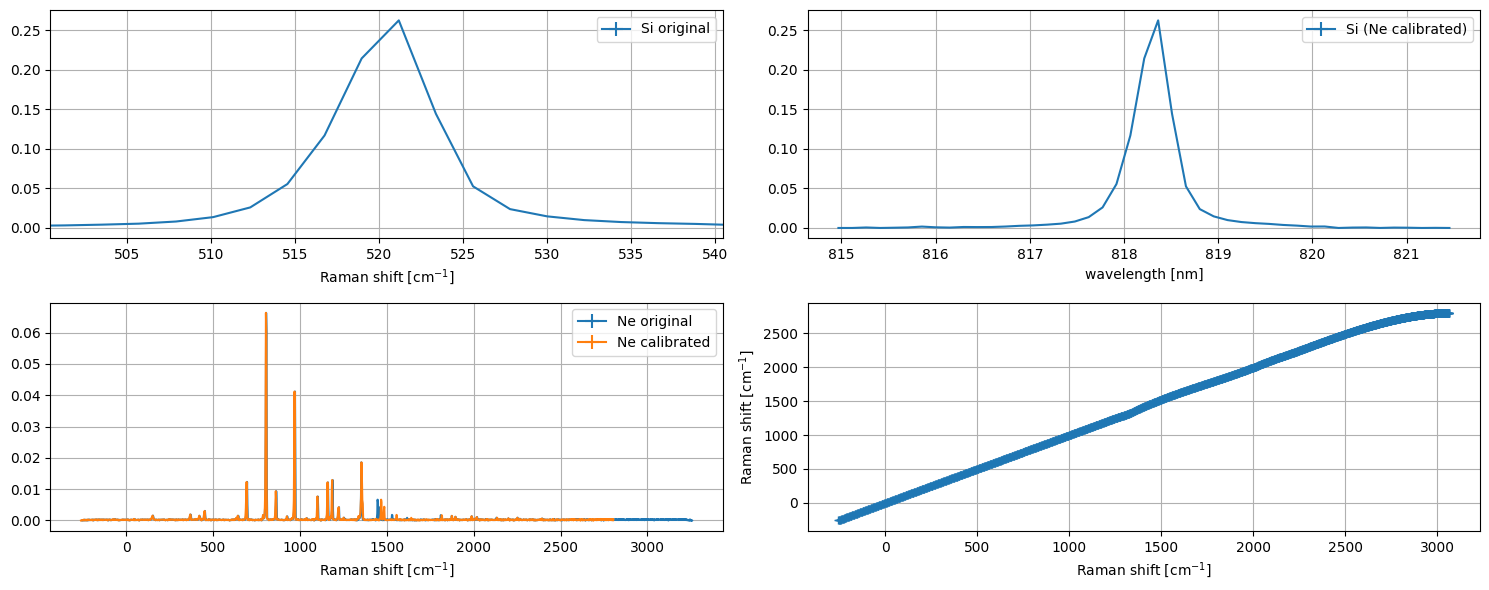

In [18]:
# we can calibrate Ne according to the calibration curve derived using Neon peaks
spe_ne_cm1 = model_neon1.process(spe_neon,convert_back=True)

# we can calibrate Si according to the calibration curve derived using Neon peaks
#spe_sil_x1_cm1 = model_neon.process(spe_sil,convert_back=True)

fig, axes = plt.subplots(2,2,figsize=(15,6))

ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

spe_sil.plot(ax=ax1,label="Si original")
#spe_sil_x1_cm1.plot(ax=ax1,label="Si (Ne calibrated)")
ax1.set_xlim(520.45-20,520.45+20)
ax1.set_xlabel('Raman shift [cm$^{-1}$]')
ax1.grid()

spe_sil_x1_nm = model_neon.process(spe_sil,convert_back=False)
spe_sil_x1_nm.plot(ax=ax2,label="Si (Ne calibrated)")
ax2.set_xlabel('wavelength [nm]')
ax2.grid()


spe_neon.plot(ax=ax3,label="Ne original")
spe_ne_cm1.plot(ax=ax3,label="Ne calibrated")
ax3.set_xlabel('Raman shift [cm$^{-1}$]')
ax3.grid()

ax4.plot(spe_neon.x,spe_ne_cm1.x,marker="+")
#ax4.set_xlim(520.45-20,520.45+20)
#ax4.set_ylim(520.45-20,520.45+20)
ax4.set_xlabel('Raman shift [cm$^{-1}$]')
ax4.set_ylabel('Raman shift [cm$^{-1}$]')
ax4.grid()
fig.suptitle="Ne calibration only"
plt.tight_layout()
plt.show()

## 4.2. Laser zeroing

- The Si spectrum is processed through Ne calibration curve, which results in spectrum in wavelength (nm)
- Then the Si peak is found and fit (in nm)
- Finally the peak position is used in the laser zeroing formula , which converts the x-axis into wavenumber (cm<sup>-1</sup>)

```
def zero_nm_to_shift_cm_1(self, wl, zero_pos_nm, zero_ref_cm_1=520.45):
        return 1e7 * (1 / zero_pos_nm - 1 / wl) + zero_ref_cm_1
```        

In [19]:
# The second step of the X calibration - Laser zeroing
# 
try:           
        find_kw = {"wlen": 200, "width": 1}
        # options for finding peaks    
        fit_peaks_kw = {}
        # options for fitting peaks         
        spe_sil_ne_calib = model_neon.process(
            spe_sil, spe_units="cm-1", convert_back=False
        )   
        calmodel1.prominence_coeff = 3
        find_kw["prominence"] = (
            spe_sil_ne_calib.y_noise_MAD() * calmodel.prominence_coeff
        )        
        calmodel1.derive_model_zero(
            spe=spe_sil_ne_calib,
            ref={520.45: 1},
            spe_units=model_neon.model_units,
            ref_units="cm-1",
            find_kw=find_kw,
            fit_peaks_kw=fit_peaks_kw,
            should_fit=True,
            name="Si calibration",
            profile="Pearson4"
        )
except Exception as err:
    traceback.print_exc()

### 4.2.1  Explore laser zeroing component (optional)

In [20]:
# Now calmodel has two components , derived with Ne and Si respectively

# we can access them individually (optional)
model_neon= calmodel1.components[0]
print(type(model_neon))
print(model_neon)
model_si= calmodel1.components[1]
print(type(model_si))
print(model_si)

<class 'ramanchada2.protocols.calibration.xcalibration.XCalibrationComponent'>
Neon calibration spe (cm-1) reference (nm) model (nm) Calibration curve 22 points) (PchipInterpolator)
<class 'ramanchada2.protocols.calibration.xcalibration.LazerZeroingComponent'>
Laser zeroing using 818.3581697620177 nm 520.45 cm-1 (Pearson4)  spe (nm) reference (cm-1) model (nm) 818.3581697620177


In [21]:
# These are the Si peaks (in nm) . The top peak is ALWAYS converted to the reference value (520.45 cm<sup>-1</sup>) due to laser zeroing formula
model_si.peaks.head()

,center,fwhm,height,amplitude
0,818.35817,0.438018,0.269451,0.145588


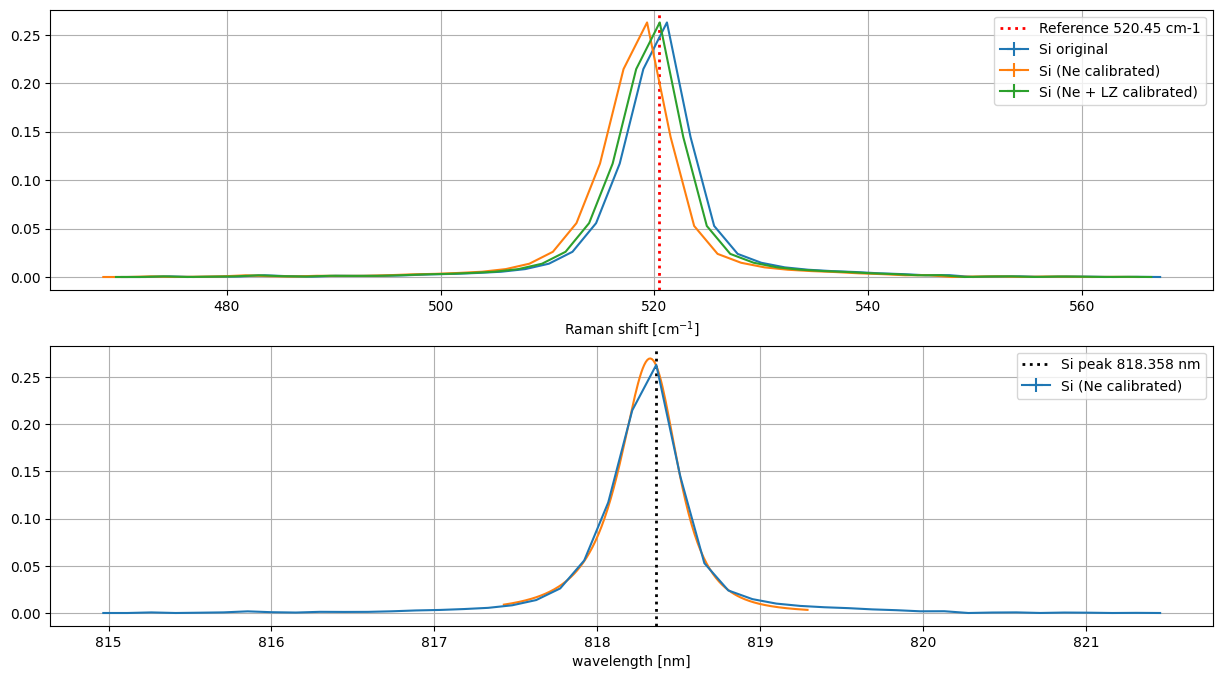

In [22]:
# These plots are for illustration , there are easier way to do calibration, see below
fig, axes = plt.subplots(2,1,figsize=(15,8))
axes[0].axvline(x=520.45, color='red', linestyle=':', linewidth=2, label="Reference 520.45 cm-1")   
axes[1].axvline(x=model_si.model, color='black', linestyle=':', linewidth=2, label="Si peak {:.3f} nm".format(model_si.model))

spe_sil_xcstep1_nm = model_neon.process(spe_sil)
spe_sil_xcstep1_cm1 = model_neon.process(spe_sil,convert_back=True)
spe_sil_xcstep2_cm1 = model_si.process(spe_sil_x1_nm)

spe_sil.plot(ax = axes[0],label="Si original")
spe_sil_xcstep1_cm1.plot(ax = axes[0],label="Si (Ne calibrated)")
spe_sil_xcstep2_cm1.plot(ax = axes[0],label="Si (Ne + LZ calibrated)")
axes[0].set_xlabel('Raman shift [cm$^{-1}$]')
# 
spe_sil_xcstep1_nm.plot(ax = axes[1],label="Si (Ne calibrated)")
model_si.fit_res.plot(ax = axes[1])
axes[1].set_xlabel("wavelength [nm]")
axes[0].grid()
axes[1].grid()

# 4.3. Apply x-calibration

In [23]:
# That's it , one line to apply both steps of the calibration 
spe_sil_calibrated = calmodel1.apply_calibration_x(spe_sil)


# 4.4. Plot and verify results

In [24]:
# let's check the Si peak with Gaussian profile
si_peak = 520.45
spe_test = spe_sil_calibrated #.trim_axes(method='x-axis',boundaries=(si_peak-50,si_peak+50))
fitres, cand = find_peaks(spe_test,profile="Gaussian")

The Si peak of the calibrated spectrum (Gaussian) 519.7178082918621


,amplitude,amplitude_stderr,center,center_stderr,sigma,sigma_stderr,fwhm,fwhm_stderr,height,height_stderr
g00_p0,1.925403,0.043342,519.717808,0.079416,3.05504,0.079396,7.194069,0.186963,0.251429,0.00566


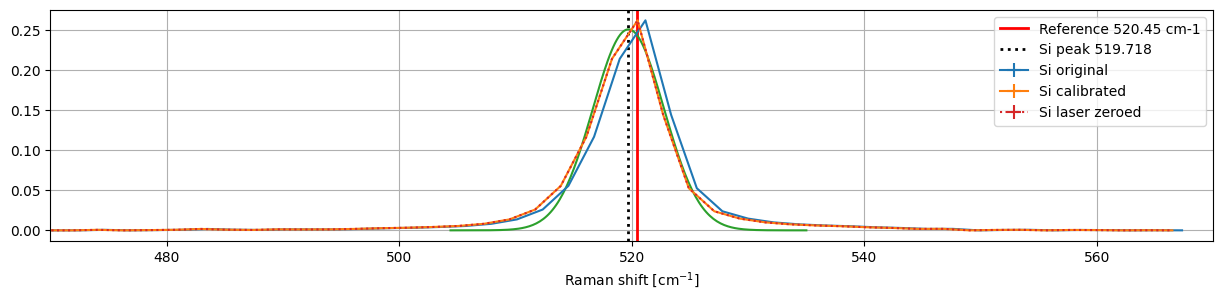

In [25]:
#Plot
fig, ax = plt.subplots(1,1,figsize=(15,3))
spe_sil.plot(label="Si original",ax=ax)
spe_sil_calibrated.plot(ax=ax,label="Si calibrated")
ax.set_xlabel('Raman shift [cm$^{-1}$]')
# 
ax.set_xlim(520-50,520+50)
ax.axvline(x=520.45, color='red', linestyle='-', linewidth=2, label="Reference 520.45 cm-1")     
fitres.plot(ax=ax,label="fit res")
spe_test.plot(ax=ax,label="Si laser zeroed", fmt=":")
df = fitres.to_dataframe_peaks().sort_values(by="height",ascending=False)
print("The Si peak of the calibrated spectrum (Gaussian)", df.iloc[0]["center"])
ax.axvline(x=df.iloc[0]["center"], color='black', linestyle=':', linewidth=2, label="Si peak {:.3f}".format(df.iloc[0]["center"]))
#cand.plot(ax=ax,label="candidates")
ax.legend()
ax.grid()
df.head()


In [26]:
# let's check the Si peak with Pearson4 profile
si_peak = 520.45
spe_sil_calibrated = calmodel1.apply_calibration_x(spe_sil)
_w = 50
spe_test = spe_sil_calibrated.trim_axes(method='x-axis',boundaries=(si_peak-_w,si_peak+_w))
fitres, cand = find_peaks(spe_test,profile="Pearson4",vary_baseline=True)

The Si peak of the calibrated spectrum (Pearson4) 520.5462447047573


,amplitude,amplitude_stderr,center,center_stderr,sigma,sigma_stderr,expon,expon_stderr,skew,skew_stderr,fwhm,fwhm_stderr,height,height_stderr,position,position_stderr
g00_p0,2.12348,0.029602,520.546245,0.104987,4.2595,0.174065,1.64626,0.092189,0.460977,0.069493,6.595053,0.091198,0.267702,0.002039,519.949883,0.02975


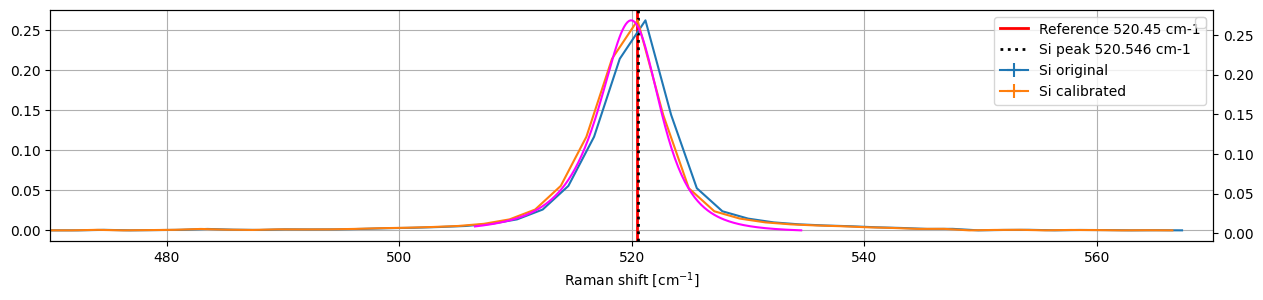

In [27]:
# plot
df = fitres.to_dataframe_peaks().sort_values(by="height",ascending=False)
print("The Si peak of the calibrated spectrum (Pearson4)", df.iloc[0]["center"])

fig, ax1 = plt.subplots(1,1,figsize=(15,3))

spe_sil.plot(label="Si original",ax=ax1)
spe_sil_calibrated = calmodel1.apply_calibration_x(spe_sil)
spe_sil_calibrated.plot(ax=ax1,label="Si calibrated")
ax1.set_xlabel('Raman shift [cm$^{-1}$]')
ax1.set_xlim(520-50,520+50)
# ax1.set_xlim(300, max(spe_sil.x))
ax1.axvline(x=520.45, color='red', linestyle='-', linewidth=2, label="Reference 520.45 cm-1")

ax1.axvline(x=df.iloc[0]["center"], color='black', linestyle=':', linewidth=2, label="Si peak {:.3f} cm-1".format(df.iloc[0]["center"]))
#cand.plot(ax=ax1,label="candidates")     
fitres.plot(ax=ax1.twinx(),label="fit res",color="magenta")
ax1.legend()
ax1.grid()
df